In [35]:
import pandas as pd
import numpy as np
from preprocess import base_data
from pathlib import Path
import hydra
import yaml
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import os
from sklearn.metrics import log_loss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)


In [36]:
file_path = '../config/config.yaml'

# ファイルを開いて内容を読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    yaml = yaml.safe_load(file)

# featuresリストを取得
features = yaml.get('features', [])

data = [pd.read_pickle(f"../features/{f}.pkl") for f in features]
data = pd.concat(data, axis=1)

In [37]:

data['Loan_Amount_per_Employee'] = data['DisbursementGross'] / data['NoEmp']

# Handle possible division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)

data['City_Count'] = data.groupby('City')['City'].transform('count')
data['State_Count'] = data.groupby('State')['State'].transform('count')
data['BankState_Count'] = data.groupby('BankState')['BankState'].transform('count')
data['Sector_Count'] = data.groupby('Sector')['Sector'].transform('count')

# 各行の欠損値の数を計算
data['missing_values_count'] = data.isna().sum(axis=1)

In [38]:
for col in ['RevLineCr','LowDoc','BankState','DisbursementYear','DisbursementMonth','DisbursementDay','LoanProcessingPeriod','Jobs_Created_per_Employee','Jobs_Retained_per_Employee','Loan_Amount_per_Employee','BankState_Count']:
    mode = data[col].mode().iloc[0]
    data[col] = data[col].fillna(mode)

In [39]:
category_features = ['State', 'BankState', 'Sector', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc', 'Franchise', 'IsSameState']

# LabelEncoderのインスタンスを作成
label_encoders = {}

for col in category_features:
    # 各カテゴリー特徴量に対してLabelEncoderを適用
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # 必要に応じて、変換したラベルエンコーダーを保存

In [40]:
train = data[data["train"]==True].drop(columns="train")
test = data[data['train'] == False]
test = test.drop(['train','MIS_Status'],axis=1)


In [41]:
train['MIS_Status'] = train['MIS_Status'].astype('int')

In [42]:
train = train.drop('City',axis=1)
test = test.drop('City',axis=1)

In [43]:
# 設定
n_splits = 5
kf = KFold(n_splits=n_splits)

# OOF予測用の空配列
oof_preds = np.zeros(train.shape[0])

# テストデータ予測用の空配列
test_preds = np.zeros(test.shape[0])

# クロスバリデーション
for train_index, val_index in kf.split(train):
    X_train, X_val = train.iloc[train_index], train.iloc[val_index]

    # ここで目的変数を設定
    y_train, y_val = X_train['MIS_Status'], X_val['MIS_Status']
    
    X_train = X_train.drop(['MIS_Status'],axis=1)
    X_val = X_val.drop(['MIS_Status'],axis=1)
    
    # モデルの訓練
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # OOF予測
    oof_preds[val_index] = model.predict_proba(X_val)[:, 1]
    
    test_preds += model.predict_proba(test)[:, 1] / n_splits

# 訓練データにOOF予測を追加
train['rf_preds'] = oof_preds

# テストデータに予測を追加
test['rf_preds'] = test_preds

In [44]:
# 訓練データとテストデータのCSVファイルに保存する列の選択
train_csv = train[['ID', 'rf_preds']]
test_csv = test[['ID', 'rf_preds']]

# CSVファイルに保存
train_csv_path = '../data/Stacking/rf/train_rf_predictions.csv'
test_csv_path = '../data/Stacking/rf/test_rf_predictions.csv'

train_csv.to_csv(train_csv_path, index=False)
test_csv.to_csv(test_csv_path, index=False)

In [9]:
X_train = train.drop('MIS_Status', axis=1)
y_train = train['MIS_Status']

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
X_train.isna().sum()

Term                              0
NoEmp                             0
NewExist                          0
CreateJob                         0
RetainedJob                       0
FranchiseCode                     0
RevLineCr                         0
LowDoc                            0
Sector                            0
ApprovalFY                        0
State                             0
BankState                         0
DisbursementGross                 0
GrAppv                            0
SBA_Appv                          0
UrbanRural                        0
DisbursementYear                  0
DisbursementMonth                 0
DisbursementDay                   0
ApprovalYear                      0
ApprovalMonth                     0
ApprovalDay                       0
IsSameState                       0
LoanProcessingPeriod              0
LoanvsApprovedAmountDifference    0
SBAGuaranteeRatio                 0
YearsSinceApproval                0
Franchise                   

In [11]:
params = {
    'objective': 'binary',  # 二値分類問題
    'metric': 'binary_logloss',  # 損失関数
    'num_leaves': 56,
    'min_data_in_leaf': 696,
    'class_weight': {1:1/7575,0:1/887},
    'random_state': 0,
    'extra_trees': True,
    'verbose': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.09342053957127938,    # default = 0.1,best=0.08
    'feature_fraction': 0.558114049397983,  # default = 1.0
}


In [12]:
# 各クラスのサンプル数を計算
class_counts = data['MIS_Status'].value_counts()

# 逆数に基づいて重みを計算
weights = 1.0 / class_counts

# 重みを正規化
weights_normalized = weights / weights.sum()

# 辞書形式でクラスの重みを設定
class_weights = {i: weights_normalized[i] for i in class_counts.index}

In [13]:
class_weights

{1: 0.10731084690476753, 0: 0.8926891530952324}

In [14]:


models = []
for seed in range(10):
    # データサンプリング
    train_sample = X_train.sample(frac=0.8, random_state=seed)
    y_sample = y_train[train_sample.index]

    # モデルの学習
    rf_clf = RandomForestClassifier(class_weight=class_weights)
    rf_clf.fit(train_sample, y_sample)

    # 検証データに対する予測
    y_pred = rf_clf.predict(X_val)
    y_pred_proba = rf_clf.predict_proba(X_val)[:, 1]  # AUCの計算に使用

    # メトリクスの計算
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    # モデルをリストに追加
    models.append(rf_clf)


In [15]:
# 3. すべてのモデルを使用してトレーニングセットとテストセットの予測を行う。
y_preds_train = []
y_preds_test = []
for model in models:
    y_preds_train.append(model.predict_proba(X_train)[:, 1])
    y_preds_test.append(model.predict_proba(X_val)[:, 1])

In [16]:
# 4. 予測結果を平均して、最終的な予測を得る。
y_pred_train = np.mean(y_preds_train, axis=0)
y_pred = np.mean(y_preds_test, axis=0)

In [17]:
print(roc_auc_score(y_val, y_pred))
total_cases = len(y_val)  # テストデータの総数
TP = (y_val == 1) & (y_pred >= 0.5)  # True positives
FP = (y_val == 0) & (y_pred >= 0.5)  # False positives
TN = (y_val == 0) & (y_pred < 0.5)  # True negatives
FN = (y_val == 1) & (y_pred < 0.5)  # False negatives

TP_count = sum(TP)
FP_count = sum(FP)
TN_count = sum(TN)
FN_count = sum(FN)

accuracy_TP = TP_count / total_cases * 100
misclassification_rate_FP = FP_count / total_cases * 100
accuracy_TN = TN_count / total_cases * 100
misclassification_rate_FN = FN_count / total_cases * 100

print("Total cases:", total_cases)
print("True positives:", TP_count, "(", "{:.2f}".format(accuracy_TP), "%)")
print("False positives:", FP_count, "(", "{:.2f}".format(misclassification_rate_FP), "%)")
print("True negatives:", TN_count, "(", "{:.2f}".format(accuracy_TN), "%)")
print("False negatives:", FN_count, "(", "{:.2f}".format(misclassification_rate_FN), "%)")

0.7613536934302225
Total cases: 8462
True positives: 7543 ( 89.14 %)
False positives: 796 ( 9.41 %)
True negatives: 91 ( 1.08 %)
False negatives: 32 ( 0.38 %)


In [18]:

print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # 0.5が閾値

# スコア関数の修正
score_funcs = [
    accuracy_score, 
    lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'), 
    lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary'),
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    roc_auc_score  # この関数は確率をそのまま使用
]

# スコアの計算（roc_auc_score以外はy_pred_binaryを使用）
scores = [
    round(f(y_val, y_pred_binary if f != roc_auc_score else y_pred), 3)
    for f in score_funcs
]

print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.902, 0.905, 0.996, 0.948, 0.761


In [19]:
from scipy.stats import mode

y_preds_new = [model.predict(test) for model in models]
y_new_pred = mode(y_preds_new, axis=0)[0]

C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32932\2231769154.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_new_pred = mode(y_preds_new, axis=0)[0]


In [20]:
submit = pd.read_csv('../data/sample_submission.csv', header=None)

submit.iloc[:, 1] = y_new_pred.ravel()
filename = 'RF_base'

submit.to_csv('outputs/' + filename + '.csv', index=False,header=None)

C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32932\2573150296.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submit.iloc[:, 1] = y_new_pred.ravel()


In [21]:
# 特徴量の重要度を取得
importance = rf_clf.feature_importances_

# 特徴量の名前を取得
feature_names = X_train.columns

# 特徴量の重要度を降順にソート
indices = np.argsort(importance)[::-1]

# 特徴量の重要度を降順に表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_names[indices[f]], importance[indices[f]]))

 1) Term                           0.058654
 2) NoEmp                          0.057696
 3) UrbanRural                     0.054250
 4) City_Count                     0.053641
 5) Loan_Amount_per_Employee       0.046073
 6) LoanProcessingPeriod           0.045569
 7) ApprovalDay                    0.038488
 8) SBA_Appv                       0.036876
 9) DisbursementYear               0.036024
10) DisbursementGross              0.035364
11) GrAppv                         0.033034
12) ApprovalMonth                  0.030115
13) Sector_Count                   0.029163
14) State                          0.029149
15) BankState                      0.029147
16) State_Count                    0.028753
17) DisbursementMonth              0.027789
18) Sector                         0.027116
19) BankState_Count                0.026926
20) RetainedJob                    0.025836
21) ApprovalYear                   0.024974
22) YearsSinceApproval             0.024836
23) ApprovalFY                  

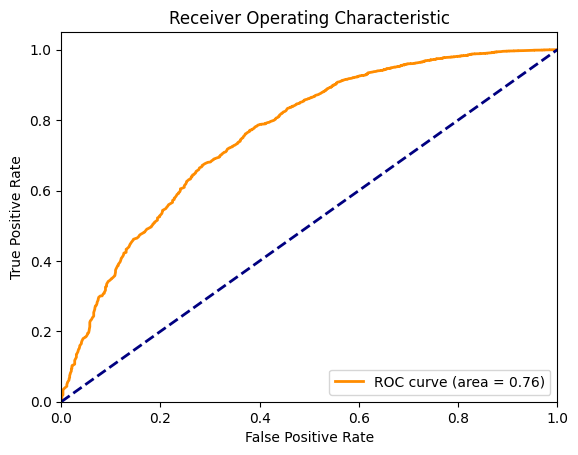

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# FPR, TPR, およびしきい値を計算する
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# AUC（Area Under Curve）を計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

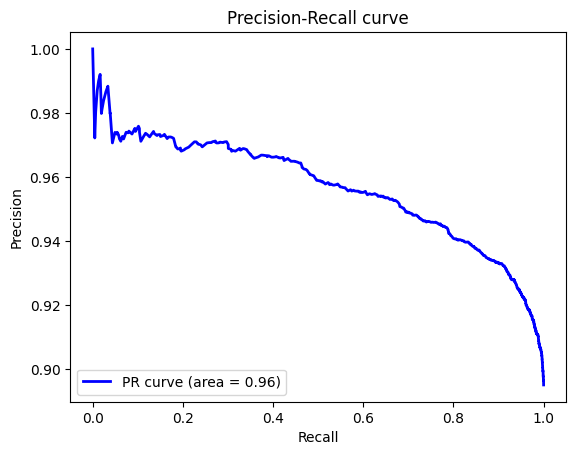

In [23]:
from sklearn.metrics import precision_recall_curve, auc

# 精度と再現率を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# PR AUCを計算
pr_auc = auc(recall, precision)

# PR曲線をプロット
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()